# Explainable Artifical Intelligence (XAI) - Tabular Data


___

**Introduction**


Machine learning (ML) systems are increasingly being integrated across various domains, from cars that drive themselves to smart assistants for improved user interactions. The widespread use of ML has increased interest in creating systems that are not only high-performing but also safe, fair, and reliable. However, unlike straightforward performance metrics such as accuracy, these additional criteria are often hard to quantify. For instance, it's difficult to list all necessary safety checks for a semi-autonomous vehicle or to fully ensure a credit scoring system is free from bias. In these situations, being able to understand how an ML system thinks becomes very important. If an ML system can explain its reasoning, we can then assess whether its logic aligns with these essential standards.


**Goals**

This notebook aims to introduce various Explainable AI (XAI) techniques for tabular, image and text data on pretrained models. 


**Outline**

*Tabular data
- SHAP
_ LIME

* Image data
- Integrated Gradients


TODO: 
- Remove and simplify sections in tabular data, save trained model and then we load it from files
- The gradient based methods, use torchvision interpret
- Use different python version 3.11 instead of 3.12. Then install ecco and Inseq


(ADD PICTURE THAT SHOWS TRADEOFF BETWEEN COMPLEXITY AND EXPLAINABILITY)

(Make graph of number of stars in this paper)

TODO: add taxonomy or decision tree on what method to use, since there are so many methods


In [ ]:
! jupyter nbextension enable --py widgetsnbextension

## Dataset

We train a machine learning model on the [Diabetes dataset](https://www.kaggle.com/datasets/mathchi/diabetes-data-set) to predict whether a patient has diabetes based on diagnostic measurements and delve into explainable AI techniques.

This dataset includes diagnostic measurements from a group of Pima Indian females, aged 21 and above, living near Phoenix, Arizona, USA. It features several medical predictor variables such as the number of pregnancies, BMI, insulin level, age, and more, along with a target variable indicating whether the individual has diabetes (encoded as 1) or not (encoded as 0). 

We'll explore both model-specific approaches, which are tailored to the specific type of machine learning model we're using, and model-agnostic approaches, which can be applied regardless of the model type. 

In [ ]:
# Read csv into pandas dataframe

import pandas as pd

#TODO: FIX RELATIVE PATH
diabetes_data = pd.read_csv('../data/diabetes.csv')
display(diabetes_data.head())
print(f"Shape of dataframe: {diabetes_data.shape}")


## Exploratory Data Analysis and Data Preprocessing


The diabetes dataset requires minimal preprocessing since it consists solely of numerical data and contains no missing values, simplifying its preparation for model training. For the purposes of this lab, and to maintain the intuitiveness of our interpretability demonstrations, we will refrain from normalizing or scaling the features. However, it's important to note that in practice, normalizing features can significantly enhance the performance of neural networks, and its omission here is solely for educational clarity.

TODO: Rephrase below

- Ensure all missing values are imputed: there are no missing values. 
- Normalize or standardize the features to have a similar scale, which is crucial for neural network training. (Although not neccesary for random forest)
- Encode categorical variables as necessary, using techniques like One-Hot Encoding.
- If target distribution is not equal, we might want to do some kind of oversampling / undersampling (rephrase this)

In [ ]:
import seaborn as sns
import scripts.eda as eda

sns.set_style('darkgrid')

# Check for missing values in dataset
print(f"Number of missing values per column: \n")
print(diabetes_data.isnull().sum())

# Check data types of features
print("\nData types of features: \n")
print(diabetes_data.dtypes)

# Check distribution of features
features = diabetes_data.drop('Outcome', axis=1)
eda.plot_histograms(diabetes_data)

# Check distribution of target
eda.plot_countplot(diabetes_data, 'Outcome')

# Check correlation between features
eda.plot_correlation_heatmap(diabetes_data)


### *Group assignment 1*
Q: Considering the EDA findings, which features do you predict will be most important for the models?

A: < Your Answer Here >

*From the EDA, features like Glucose, BMI, and Age might be particularly important for the models, given their direct relevance to diabetes risk factors as indicated by medical research. For instance, higher glucose levels are a direct indicator of diabetes, making this feature potentially significant for the model's predictions. We expect XAI techniques such as SHAP or LIME to highlight these features' contributions in individual predictions, showing high importance or impact values. If a model is well-aligned with medical understanding, these features should consistently appear as significant in the explanations, reinforcing their relevance in predicting the 'Outcome'.*


Q: How might the EDA process inform your approach to applying and interpreting the results from XAI methods?

A: < Your Answer Here >

*The EDA process informs our use of XAI methods by highlighting key data traits like feature distribution, correlations, and potential outliers, setting the stage for understanding model behavior and XAI interpretations. Features identified with skewed distributions or strong correlations to the target during EDA are expected to be pivotal in XAI analyses. Such insights enable a critical assessment of XAI outputs, prompting further scrutiny if XAI methods don't emphasize features deemed significant by EDA. This integrated approach ensures that XAI explanations align with the underlying data patterns, enhancing the interpretability and trustworthiness of model decisions.*

### Split the dataset

In [ ]:
from sklearn.model_selection import train_test_split

# Drop target column from dataset
X = diabetes_data.drop(columns=['Outcome'], axis=1)
# Isolate target to seperate dataset
y = diabetes_data['Outcome']

# Split the data into training and test set.
# The test size specifies that 20% of the data will be used for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



## Train models

In this section we train two different models. The first model is a **Random Forest** and the second is a **Feedforward Neural Network**.

Tree-based models like Random Forests are inherently more explainable due to their decision-making process, which mimics human decision-making by splitting data based on feature values. In contrast, deep learning models, due to their complex network of layers and non-linear transformations, lack this intuitive explainability, making it challenging to understand how they arrive at specific predictions.

### Random Forest

A random forest is a machine learning model that combines multiple decision trees to improve prediction accuracy, but with many trees the model becomes more complicated and it becomes difficult to trace back through the many paths to understand the rationale behind its decisions.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics

import warnings

# Ignore FutureWarning
warnings.filterwarnings(action='ignore', category=FutureWarning)

random_forest_classifier = RandomForestClassifier(random_state=80)
random_forest_classifier.fit(X_train.values, y_train.values)

# Make prediction on the testing data
y_pred = random_forest_classifier.predict(X_test.values)

# Get performance metrics
print(metrics.classification_report(y_pred, y_test))
print(f"Model Accuracy: {metrics.accuracy_score(y_pred, y_test):.3f} \n")


In [ ]:
from joblib import dump, load

# Save the model to a file
dump(random_forest_classifier, 'random_forest_classifier.joblib')

# Load the model from the file
random_forest_classifier = load('random_forest_classifier.joblib')


### Neural Network


https://www.learnpytorch.io/02_pytorch_classification/
https://machinelearningmastery.com/develop-your-first-neural-network-with-pytorch-step-by-step/

In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    torch.manual_seed(seed_value)  # PyTorch
    torch.cuda.manual_seed_all(seed_value)  # for multi-GPU
    np.random.seed(seed_value)  # NumPy
    random.seed(seed_value)  # Python
    torch.backends.cudnn.deterministic = True  # For CUDA backend, making computations deterministic

# Call the function with your desired seed
set_seed(42)


In [ ]:
class NNClassifier(nn.Module):
    def __init__(self):
        super(NNClassifier, self).__init__()
        # Define the layers of the network
        self.hidden1 = nn.Linear(8, 12)  # First hidden layer
        self.hidden2 = nn.Linear(12, 8)  # Second hidden layer
        self.output = nn.Linear(8, 1)    # Output layer

    def forward(self, x):
        # Forward pass through the network with activation functions applied directly
        x = F.relu(self.hidden1(x))  # Apply ReLU activation function after first hidden layer
        x = F.relu(self.hidden2(x))  # Apply ReLU activation function after second hidden layer
        x = torch.sigmoid(self.output(x))  # Apply Sigmoid activation function after output layer
        return x


In [ ]:
nn_model = NNClassifier()

# Loss function
loss_fn = nn.BCELoss()  # binary cross entropy

# Optimizer
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs = 200  

for epoch in range(num_epochs):
    nn_model.train()  
    for inputs, targets in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = nn_model(inputs)

        # Calculate loss
        loss = loss_fn(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
nn_model.eval() 
with torch.no_grad():
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    correct = 0
    total = 0
    for inputs, targets in test_loader:
        outputs = nn_model(inputs)
        # Convert probabilities to binary predictions
        predicted = (outputs.data > 0.5).float()  
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {accuracy:.2f}%')


In [ ]:
# Save model
torch.save(nn_model, 'nn_classifier.pth')

# Load the model
nn_model = torch.load('model.pth')

## Get Explanations

In this section, we'll explore XAI techniques that offer insights on how our Random Forest and Neural Network make predictions. Model-agnostic methods like LIME and SHAP are applicable to different types of models and are mainly used for local explanations, highlighting the contribution of each feature to individual predictions. SHAP can also be used to offer a global explanation, allowing users to understand the overall impact of features on model predictions across the dataset.On the other hand, Integrated Gradients is a model-specific method tailored specifically for deep learning models. It traces the importance of each input feature through the network's gradients. By leveraging these techniques, we can better understand how our models make decisions, enhancing transparency and trust in their predictions.

### Model Agnostic Explanation Methods

#### Local Interpretable Model-agnostic Explanations (LIME)


- https://www.geeksforgeeks.org/introduction-to-explainable-aixai-using-lime/
- https://github.com/marcotcr/lime?tab=readme-ov-file




LIME  is a technique that explains individual predictions of any classifier by approximating it locally with an interpretable model. It works by perturbing the input data and observing how the predictions change, helping to identify which features significantly influence the output. LIME provides simple explanations that can help users understand why a model made a particular decision for a specific instance.

![Alt text](../images/lime.png)


LIME makes complex models easier to understand by focusing on one data point at a time. Think of the model as a complicated landscape with hills and valleys. LIME looks closely at the flat ground around one point (let's call it "X") to understand how the model decides things just there. It's like drawing a simple, straight line on the ground around "X" to represent the model's decision-making process nearby, without worrying about the whole landscape. This line helps us see why the model made its decision for "X," using a simpler explanation that ignores the complex parts far away from "X."





works on all models that has .predict_proba



In [ ]:
import lime
from lime import lime_tabular
import numpy as np
import warnings

%matplotlib inline

# Suppress FutureWarning
warnings.filterwarnings(action='ignore', category=FutureWarning, module='lime')

# Create a LimeTabularExplainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['no_diabetes', 'diabetes'],
    mode='classification',
    random_state=80
)

In [ ]:
def explain_rf_instance_with_lime(data_row_index: int, num_features: int) -> None:
    exp = explainer.explain_instance(
        data_row=X_test.iloc[data_row_index], 
        predict_fn=random_forest_classifier.predict_proba,  # Prediction function from the trained model
        num_features=num_features  # Number of features to consider for the explanation
    )
    
    # Display the explanation in the notebook
    exp.show_in_notebook(show_table=True)


In [ ]:
# TODO: Create a list and loop over it

# Analyze here an instance of a person with diabetes
explain_rf_instance_with_lime(data_row_index=5, num_features=5)

# Analyzer here an instance of another person with diabetes
explain_rf_instance_with_lime(data_row_index=7, num_features=5)

# Analyze here an instance of a person without diabetes
explain_rf_instance_with_lime(data_row_index=1, num_features=5)

# Analyze here an instance of another person without diabetes
explain_rf_instance_with_lime(data_row_index=3, num_features=5)


In [ ]:
# Define a prediction function for the neural network model
def nn_model_predict(x, model=nn_model):
    # Convert the input data to PyTorch tensors with the appropriate data type
    x_tensor = torch.tensor(x, dtype=torch.float32)

    # Set the neural network model to evaluation mode to disable dropout or batch norm layers if present
    nn_model.eval()
    
    # Compute the model's output without tracking gradients, as we don't need them for inference
    with torch.no_grad():
        outputs = model(x_tensor)
    
    # Apply sigmoid to the outputs to obtain probabilities, assuming a binary classification task
    probs = torch.sigmoid(outputs).numpy()
    
    # Return the probabilities as a 2D array where each row represents an instance and columns represent class probabilities
    # Here, it's assumed the model output is for one class, and we derive the second class's probability as (1 - first class's probability)
    return np.hstack((1 - probs, probs))

In [ ]:
import numpy as np
from lime.lime_tabular import LimeTabularExplainer


# Create a LimeTabularExplainer
explainer = LimeTabularExplainer(X_train.values, 
                                 feature_names=X_train.columns, 
                                 class_names=['no_diabetes', 'diabetes'], 
                                 mode='classification')

# Choose a specific instance to explain
instance = X_test.values[0]

# Generate the explanation for the instance
exp = explainer.explain_instance(instance, nn_model_predict, num_features=5)

# Print the explanation
exp.show_in_notebook(show_table=True)

Todo: Inspect instances here

Interpretation:
- The model is 65% confident that this perrson has diabetes
- The values of age, BMI and insulin increases this person's chance to be classified as diabetic
- While the values of glucose and bloodpressure decreases it

### *Group assignment 2*
Q: What do you observe in the explanations provided by LIME for instances of people with diabetes in the random forest model? Are there any common features contributing to the predictions?

A: < Your Answer Here >

*AHERE*


Q: How do the explanations differ between instances of people with diabetes and those without diabetes in the random forest model? What insights can we gain from these differences?

A: < Your Answer Here >

*AHERE*

Q: What do you observe in the explanations provided by LIME for instances of people with diabetes and without diabetes in the neural network? Do you observe any differences in the two models?

A: < Your Answer Here >

*AHERE*

Q: How do you think the number of features selected for explanation (num_features) affects the interpretability of the explanations?

A: < Your Answer Here >

*The number of features selected for explanation (num_features) directly impacts the interpretability of the explanations provided by LIME. A smaller number of features may result in more concise and focused explanations, making it easier to identify the most influential factors driving the model's predictions. However, too few features may overlook important information, while too many features can lead to information overload and decreased interpretability.*


Q: In what real-world scenarios could explainable AI techniques like LIME be particularly useful?

A: < Your Answer Here >

*Explainable AI techniques like LIME can be particularly useful in critical domains such as healthcare, finance, and criminal justice, where model decisions have significant consequences for individuals. For example, in healthcare, LIME explanations can help clinicians understand the factors influencing a patient's diagnosis or treatment recommendation, leading to more informed decision-making and improved patient outcomes.*


#### Disadvantages of Lime

- Sensitivity to perturbations: Explanations may vary based on perturbation choice.
- Local interpretability: Primarily offers insights at the individual prediction level.
- Computational intensity: Generating explanations can be resource-intensive.
- Model dependency: Effectiveness varies based on model complexity.
- Limited support for non-tabular data: Less effective for text or image data.
- Indirect solution relying on surrogate model: Explanation quality depends on surrogate fit, with potential high computational costs.
- Introduction of uncertainty through sampling: Non-deterministic behaviors and variable explanations may result from sampling.

#### SHapley Additive exPlanations (SHAP)

SHAP decomposes model predictions into contributions from each input feature, using concepts from cooperative game theory. It calculates the Shapley value for each feature, which represents the average marginal contribution of that feature across all possible feature subsets, akin to assessing a team member's value by imagining the team's performance with and without them in every possible team composition. This method ensures fairness and accuracy in attributing the prediction's "credit" to individual features by considering their impact both in isolation and in combination with others. By providing both local explanations (how features affect an individual prediction) and global insights (overall feature importance), SHAP helps demystify complex model decisions, making them accessible and interpretable for users, thereby enhancing trust and understanding in AI systems.

**Local Explanations**

SHAP offers powerful visual tools to interpret individual predictions from complex models, primarily through decision plots and force plots. Both plots provide local explanations but differ in their presentation and emphasis.

**Decision Plots**:Decision plots show the cumulative effect of features on a model's output, starting from a base value. Each horizontal line represents a feature's contribution, with the plot tracing a path that cumulatively adds these contributions to arrive at the final prediction. To interpret a decision plot:
1. **Start at the Base**: Identify the base value, the average prediction across the dataset.
2. **Follow the Path**: Trace the path, noting how each feature shifts the prediction up (positive contribution) or down (negative contribution).
3. **End at the Prediction**: The path's end shows the final prediction, after accounting for all features.
4. **Analyze Feature Impact**: Color coding or annotations may indicate feature values, helping understand their individual impact.

**Force Plots**:
Force plots provide a more intuitive, interactive visualization of an instance's prediction, showing how each feature's value pushes the prediction higher or lower. To interpret a force plot:
1. **Base Value**: Note the base value, a reference point for the prediction.
2. **Feature Contributions**: Observe how features are represented as vectors, pushing the prediction away from the base value.
3. **Positive vs. Negative**: Positive contributions push towards one end (often the right for higher values), while negative contributions push towards the opposite.
4. **Final Prediction**: The sum of the base value and all contributions gives the final prediction, represented at the plot's end.

While decision plots offer a detailed, step-wise breakdown of feature contributions, force plots provide a more dynamic, intuitive representation of how features influence a prediction. Both plots are invaluable for dissecting a model's decision-making process, offering clear insights into the role of individual features in shaping a prediction.

In [ ]:
import shap
shap.initjs()

def explain_random_forest_instance_with_shap(model, data_row_index: int, num_features: int, plot_type: str = 'force'):
    # Initialize the explainer
    explainer = shap.TreeExplainer(model)

    # Compute SHAP values for the specific instance
    shap_values = explainer.shap_values(X_test.iloc[data_row_index])

    # Display the explanation
    if plot_type == 'force':
        plot = shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[data_row_index])
    elif plot_type == 'decision':
        plot = shap.decision_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[data_row_index])
    else:
        raise ValueError(f"Invalid plot_type: {plot_type}. Expected 'force' or 'decision'.")
    
    return plot

In [ ]:
# Move these indices to above
indices_to_explore = [1, 3, 5, 7]
for index in indices_to_explore:
    plot = explain_random_forest_instance_with_shap(random_forest_classifier, data_row_index=index, num_features=5, plot_type = 'force')
    display(plot) 

In [ ]:
import shap
import torch

def explain_nn_instance_with_shap(model, data_row_index: int, num_features: int, plot_type: str = 'force', num_samples: int = 100) -> None:
    # Define a predict function for your model
    def predict_fn(x):
        # Convert the data to PyTorch tensors
        x_tensor = torch.tensor(x, dtype=torch.float32)
        
        # Set the model to evaluation mode
        model.eval()
        
        # Compute the model output
        with torch.no_grad():
            outputs = model(x_tensor)
        
        # Convert the output to probabilities (assuming binary classification)
        probs = torch.sigmoid(outputs).numpy()
        
        # Return the probabilities as a 2D array (n_samples, n_classes)
        return np.hstack((1 - probs, probs))

    # Reduce the number of background data samples
    # A large number of samples can slow down the computation
    X_train_summary = shap.kmeans(X_train, num_samples)

    # Initialize the explainer
    explainer = shap.KernelExplainer(predict_fn, X_train_summary)

    # Compute SHAP values for the specific instance
    shap_values = explainer.shap_values(X_test.iloc[data_row_index])

    # Display the explanation
    if plot_type == 'force':
        plot = shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[data_row_index])
    elif plot_type == 'decision':
        plot = shap.decision_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[data_row_index])
    else:
        raise ValueError(f"Invalid plot_type: {plot_type}. Expected 'force' or 'decision'.")
    
    return plot

In [ ]:

# Maybe just compare one instance to the same instance in the random forest model
explain_nn_instance_with_shap(nn_model, data_row_index=1, num_features=5, plot_type='force')

### *Group assignment 3*
Q: INSERT Q HERE

A: < Your Answer Here >

*AHERE*


Q: INSERT Q HERE

A: < Your Answer Here >

*AHERE*


**Global Explanations**

Global explanations in SHAP offer a comprehensive overview of how features influence model predictions across the entire dataset, providing insights into the overall importance and interaction of features.

- **Summary Plot**: Aggregates values for all features across instances, revealing the most impactful features and their impact distribution.
- **Feature Importance Plot**: Ranks features by the sum of value magnitudes, providing a clear overview of overall feature importance.
- **Beeswarm Plot**: Organizes values in a dense pattern, illustrating the distribution and variability of feature impacts on predictions.
- **Dependence Plot**: Displays the relationship between a feature's value and its value, highlighting potential feature interactions.
- **Interaction Values Plot**: Visualizes feature interactions, showing how the impact of one feature on predictions depends on another feature.

In [ ]:
explainer = shap.Explainer(random_forest_classifier)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)



https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability
https://towardsdatascience.com/introducing-shap-decision-plots-52ed3b4a1cba

Interpretation:


- Y-axis indicates the feature names in order of importance from top to bottom.
- X-axis represents the SHAP value, which indicates the degree of change in log odds.
- The color of each point on the graph represents the value of the corresponding feature, with red indicating high values and blue indicating low values.
- Each point represents a row of data from the original dataset.

In [ ]:
# Display summary plot of label 0

shap.summary_plot(shap_values[0], X_test)

In [ ]:
# for the label 1 it will be flipped
shap.summary_plot(shap_values[1], X_test)

### *Group assignment 4*
Q: What features are most important in the random forest model?

A: < Your Answer Here >

*AHERE*


Q: What features are most important in the neural network model?

A: < Your Answer Here >

*AHERE*

Q: How do the global differ with the individual explanations?

A: < Your Answer Here >

*AHERE*

Q: INSERT Q HERE

A: < Your Answer Here >

*AHERE*

In [ ]:
# TODO: do we want interaction?

## Model-specific methods


FOCUS ON IMAGES HERE: https://captum.ai/tutorials/TorchVision_Interpret

Different technics such as DeepLIFT, Grad-CAM, or Integrated Gradients can be leveraged to explain deep-learning models.


https://towardsdatascience.com/explainable-neural-networks-recent-advancements-part-4-73cacc910fef

This section demonstrates how to apply XAI methods on image data and visualizes the attributions for each pixel by overlaying them on the image.

The interpretation algorithms that we use in this notebook are Integrated Gradients (w/ and w/o noise tunnel), GradientShap, Occlusion, and LRP. A noise tunnel allows to smoothen the attributions after adding gaussian noise to each input sample.


In [ ]:
! pip install torchvision

In [ ]:
! pip install Pillow

In [ ]:
! pip install chardet

In [ ]:
! pip install captum

In [2]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import LRP
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule, Alpha1_Beta0_Rule

In [3]:
# Load model
model = models.resnet50(weights='DEFAULT')

# model = models.resnet18(pretrained=True)
# Set to eval mode 
model = model.eval()

In [ ]:
# If wget not found on mac: install brew, then 'brew install wget'
! wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json


In [4]:
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

In [6]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('../images/racoon.jpg')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

In [7]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: Persian_cat ( 0.10289326310157776 )


## Integrated Gradients

In [8]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

Predicted: Persian_cat ( 0.10289326310157776 )


Let us compute attributions using Integrated Gradients and smoothens them across multiple images generated by a noise tunnel. The latter adds gaussian noise with a std equals to one, 10 times (nt_samples=10) to the input. Ultimately, noise tunnel smoothens the attributions across nt_samples noisy samples using smoothgrad_sq technique. smoothgrad_sq represents the mean of the squared attributions across nt_samples samples.

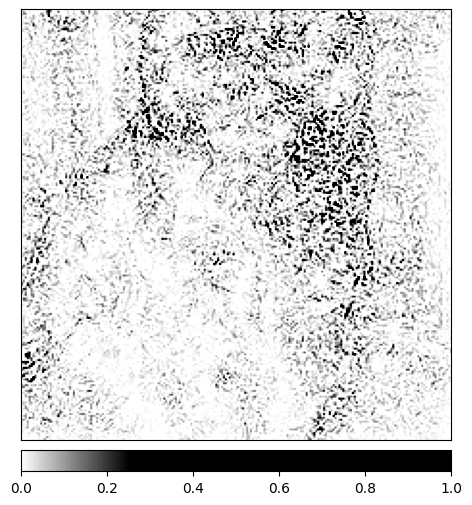

In [9]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

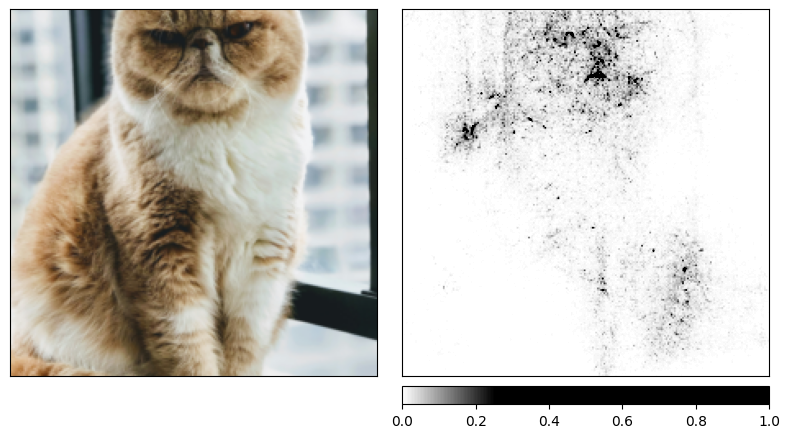

In [10]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

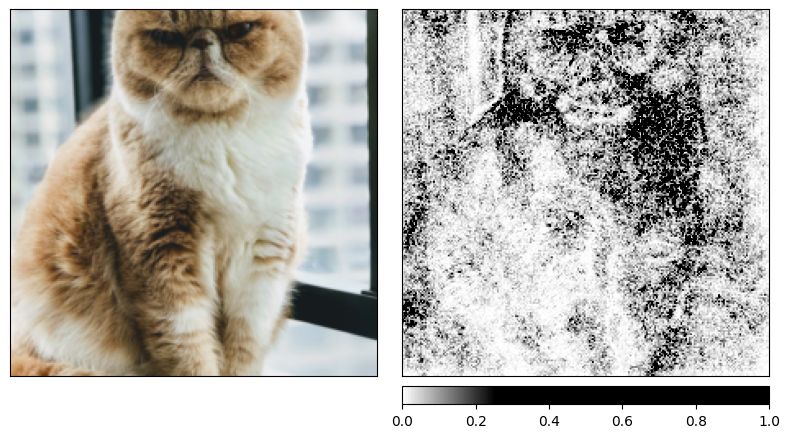

In [11]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [237]:
idx_to_labels

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

The index for 'beagle' is: 162


## SHAP

https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20MobilenetV2%20using%20the%20Partition%20explainer%20%28PyTorch%29.html

In [ ]:
! pip install opencv-python

In [20]:
import shap


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


X, y = shap.datasets.imagenet50()

# Get ImageNet 1000 class names

# Extract class names from the JSON data
# The values in the ImageNet class index JSON are usually lists where the first element is a numeric class ID (as a string)
# and the second element is the class name (as a string). We're interested in the class names.
class_names = [v[1] for v in idx_to_labels.values()]

# Prepare data transformation pipeline

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x


def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x


transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(lambda x: x * (1 / 255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean=(-1 * np.array(mean) / np.array(std)).tolist(),
        std=(1 / np.array(std)).tolist(),
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

In [21]:
def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img))
    img = img.to(device)
    output = model(img)
    return output

In [23]:
# Check that transformations work correctly
Xtr = transform(torch.Tensor(X))
out = predict(Xtr[1:3])
classes = torch.argmax(out, axis=1).cpu().numpy()
print(f"Classes: {classes}: {np.array(class_names)[classes]}")

Classes: [132 814]: ['American_egret' 'speedboat']


In [24]:
# This takes toooo long, 20 minutes

topk = 4
batch_size = 50
n_evals = 10000

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", Xtr[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    Xtr[1:2],
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],
)

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [19:25, 1165.51s/it]             


In [25]:
(shap_values.data.shape, shap_values.values.shape)
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values[0], -1, 0)]

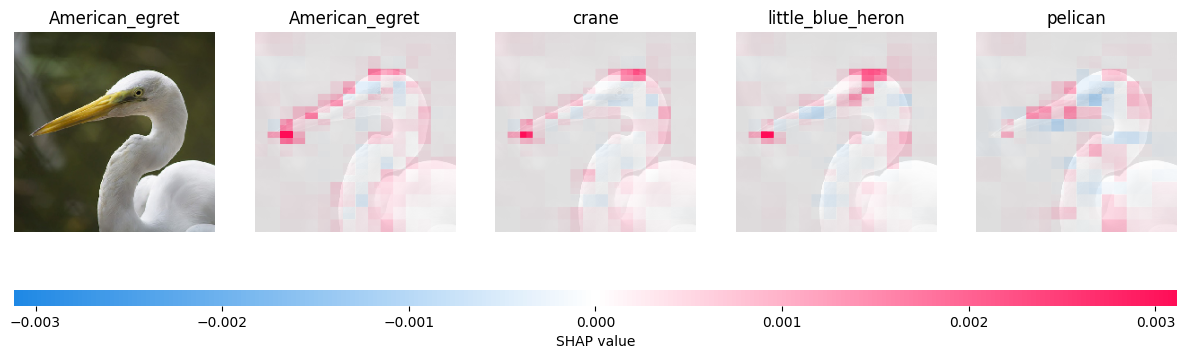

In [26]:
shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
    true_labels=[class_names[132]],
)

In [ ]:
## Occlusion

In [52]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

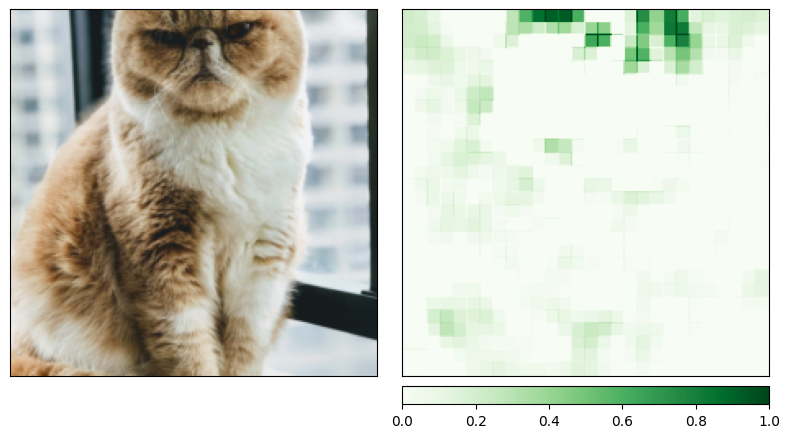

In [53]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

## Ablation

In [27]:
! pip install pycocotools

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.7-cp312-cp312-macosx_11_0_arm64.whl size=81011 sha256=d1392225bd0460857cde8f51c0b6f60d56b45db923e1a118228ff2c43c28fa39
  Stored in directory: /Users/anniewong/Library/Caches/pip/wheels/1e/b8/6d/646852bb348f96f4928351fc4b023cdace78cb8f43d2244ded
Successfully built pycocotools


In [ ]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision import models

from captum.attr import visualization as viz
from captum.attr import FeatureAblation

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import os
import json

In [228]:
# Download subset of COCO
from pycocotools.coco import COCO
import requests
import numpy as np
from PIL import Image
import os

# Path to the downloaded annotations file
annotation_file = 'coco/instances_val2017.json'

# Initialize COCO API for instance annotations
coco = COCO(annotation_file)

# Specify the category names you are interested in (e.g., "dog", "cat")
categories = ['dog', 'cat']

# Get category IDs
cat_ids = coco.getCatIds(catNms=categories)

# Get the image IDs for images containing the specified categories
img_ids = coco.getImgIds(catIds=cat_ids)

# Specify the number of images you want to download
num_images_to_download = 30

# Download images and their masks
for img_id in img_ids[:num_images_to_download]:
    img = coco.loadImgs(img_id)[0]
    img_url = img['coco_url']
    extension = os.path.splitext(img_url)[1]  # Extract the file extension

    # Format the image ID as a zero-padded string
    formatted_img_id = f"{img_id:012d}"  # 12 digits with zero-padding

    # Download the image
    img_name = f"{formatted_img_id}{extension}"  # Use the formatted image ID as the filename
    img_data = requests.get(img_url).content
    with open(img_name, 'wb') as handler:
        handler.write(img_data)
    print(f'Downloaded image with ID {formatted_img_id}')

    # Get annotations and create a mask
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    mask = np.zeros((img['height'], img['width']), dtype=np.uint8)
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann) * 255)  # Scale mask to 0-255

    # Save the mask
    mask_name = f"mask_{formatted_img_id}.png"  # Use the formatted image ID in the mask filename
    Image.fromarray(mask).save(mask_name)
    print(f'Saved mask {mask_name} for image ID {formatted_img_id}')



loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
Downloaded image with ID 000000179392
Saved mask mask_000000179392.png for image ID 000000179392
Downloaded image with ID 000000401991
Saved mask mask_000000401991.png for image ID 000000401991
Downloaded image with ID 000000022892
Saved mask mask_000000022892.png for image ID 000000022892
Downloaded image with ID 000000241326
Saved mask mask_000000241326.png for image ID 000000241326
Downloaded image with ID 000000189806
Saved mask mask_000000189806.png for image ID 000000189806
Downloaded image with ID 000000219578
Saved mask mask_000000219578.png for image ID 000000219578
Downloaded image with ID 000000375278
Saved mask mask_000000375278.png for image ID 000000375278
Downloaded image with ID 000000554291
Saved mask mask_000000554291.png for image ID 000000554291
Downloaded image with ID 000000169076
Saved mask mask_000000169076.png for image ID 000000169076
Downloaded image with ID 000000071226
Saved 

loading annotations into memory...


Done (t=0.21s)
creating index...
index created!


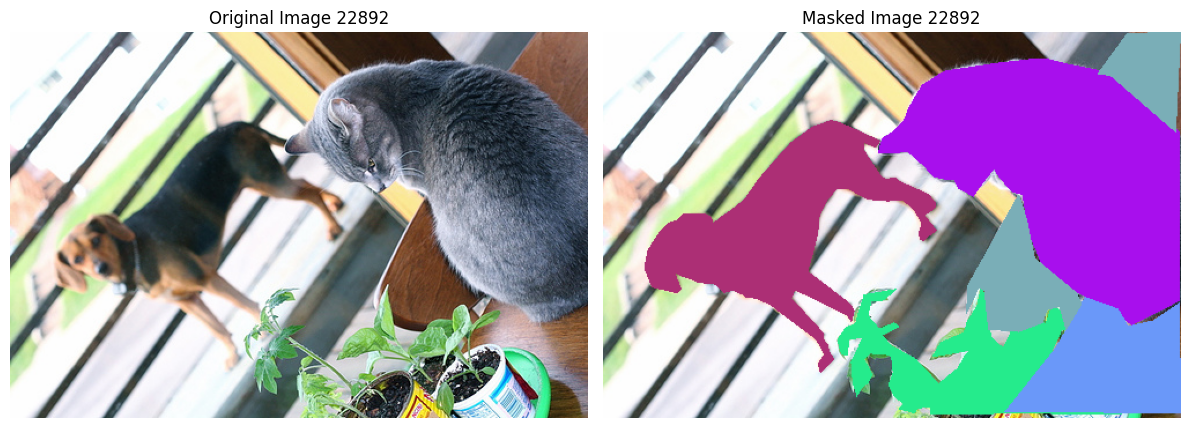

In [229]:
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
import os

# Initialize COCO api for instance annotations
coco_dir = 'coco'
coco = COCO(os.path.join(coco_dir, 'instances_val2017.json'))

# Function to generate a unique color for each object
def get_unique_color(index):
    np.random.seed(index)  # Ensure reproducibility for each index
    return np.random.randint(0, 255, 3)  # Generate a random color

# Function to get the original and masked image with unique colors for each mask
def get_images(image_id):
    # Load the image
    img_info = coco.loadImgs(image_id)[0]
    img_path = os.path.join(coco_dir, img_info['file_name'])
    img = Image.open(img_path)
    original_img = np.array(img)

    # Load and process annotations
    ann_ids = coco.getAnnIds(imgIds=img_info['id'])
    anns = coco.loadAnns(ann_ids)

    # Create a masked image (copy of original)
    masked_img = original_img.copy()

    # Apply a unique color mask for each annotation
    for index, ann in enumerate(anns):
        mask = coco.annToMask(ann)
        color = get_unique_color(index)
        masked_img[mask > 0] = color  # Apply color to masked regions

    return original_img, masked_img  # Return both original and masked images

# Visualize the original and masked images for a single image ID
# image_id = 543581  # The single image ID you want to visualize

image_id = 22892

original_img, masked_img = get_images(image_id)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Adjusted for 1 row with 2 images

# Original image
axs[0].imshow(original_img)
axs[0].axis('off')
axs[0].set_title(f"Original Image {image_id}")

# Masked image
axs[1].imshow(masked_img)
axs[1].axis('off')
axs[1].set_title(f"Masked Image {image_id}")

plt.tight_layout()
plt.show()


In [230]:
# uses torchvision transforms to convert a PIL image to a tensor and normalize it
img_to_resnet_input = T.Compose([
 T.ToTensor(),
 T.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )    
])

def classify(img, print_result=True):
    output = model(img_to_resnet_input(img).unsqueeze(0))
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    prediction_score.squeeze_()
    pred_label_idx.squeeze_()
    if print_result:
        labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
        with open(labels_path) as json_data:
            idx_to_labels = json.load(json_data)
        predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
        print('Predicted:', predicted_label, "id =", pred_label_idx.item(), 'with a score of:', prediction_score.squeeze().item())
    return pred_label_idx.item(), prediction_score.item()

In [232]:
image_id= "000000022892"
img = Image.open(f'coco/{image_id}.jpg')
predicted_class, prediction_score = classify(img)

# Note that the model is trained for classification, and expects images containing one object not a whole scene.
mask_img = Image.open(f'coco/mask_{image_id}.png')

Predicted: greenhouse id = 580 with a score of: 0.007455330342054367


With the availability of a segmentation mask, we can quickly exclude parts of the image to see how they affect the classification output.
In case of an image input, the feature mask is also a 2D image of the same size, where each pixel in the mask indicates the feature group it belongs to via an integer value. Pixels of the same value define a group.

This means we can readily use segmentation masks as feature masks in Captum! Let us see how:




In [239]:
# convert the mask image to a numpy array of the expected shape (count, channels, height, width)
feature_mask = np.array(mask_img.getdata()).reshape(1, 1, mask_img.size[1], mask_img.size[0])

print(np.unique(feature_mask))



[  0 255]


In [243]:
# Feature group for void
feature_mask[feature_mask == 255] = 1 # feature group for void


In [234]:
# Todo: change model name to reset so we don't overwrite models
# This takes some time to run
ablator = FeatureAblation(model)

attribution_map = ablator.attribute(
    img_to_resnet_input(img).unsqueeze(0),
    target=predicted_class,
    feature_mask=torch.tensor(feature_mask))

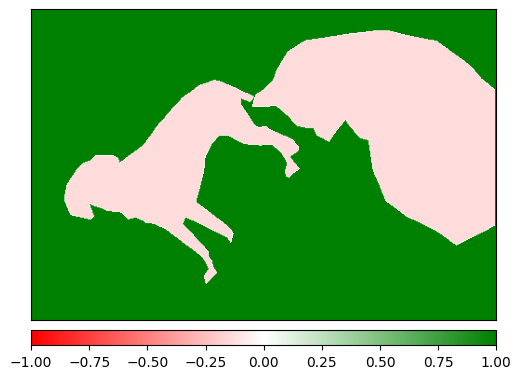

In [235]:
# Visualize 
attribution_map = attribution_map.squeeze().cpu().detach().numpy()
# adjust shape to height, width, channels 
attribution_map = np.transpose(attribution_map, (1,2,0))
_ = viz.visualize_image_attr(attribution_map,
                             method="heat_map",
                             sign="all",
                             show_colorbar=True)

ImageNet does have a class for a TV monitor with class_id = 664 according to the idx_to_labels map we loaded in section 1.

In [240]:
import json
import os

# Load the ImageNet class index file
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

# Search for the index corresponding to 'beagle' with synset ID 'n02088364'
beagle_index = None
for idx, label_info in idx_to_labels.items():
    if label_info[0] == 'n02088364':
        beagle_index = idx
        break

if beagle_index is not None:
    print(f"The index for 'beagle' is: {beagle_index}")
else:
    print("Beagle not found in the class index.")


The index for 'beagle' is: 162


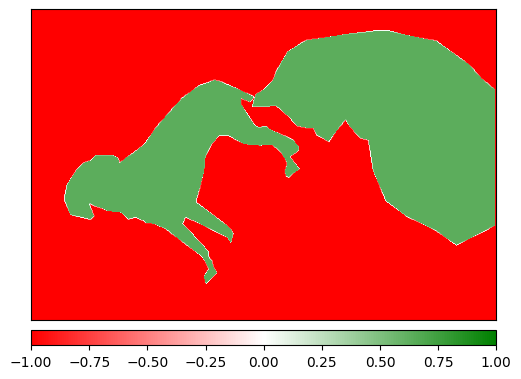

In [241]:
# Inspecting influential images parts for alternative classification

attribution_map = ablator.attribute(
    img_to_resnet_input(img).unsqueeze(0),
    target=162,
    feature_mask=torch.tensor(feature_mask))

attribution_map = attribution_map.squeeze().cpu().detach().numpy()
# adjust shape to height, width, channels 
attribution_map = np.transpose(attribution_map,  (1,2,0))

_ = viz.visualize_image_attr(attribution_map,
                             method="heat_map",
                             sign="all",
                             show_colorbar=True)

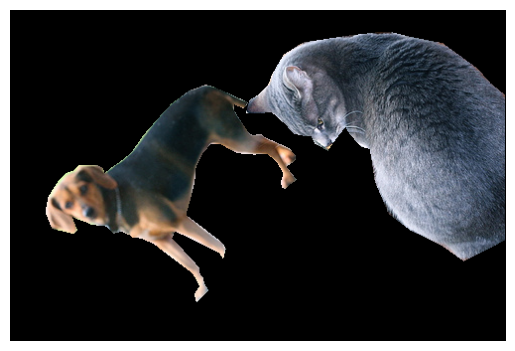

In [247]:
import cv2


cV2_mask = np.array(feature_mask)
cV2_mask[feature_mask == 0] = 0
cV2_mask[feature_mask == 1] = 0
cV2_mask = np.expand_dims(cV2_mask.squeeze(), axis=2).astype(np.uint8)

img_arr = np.transpose(T.ToTensor()(img).numpy(),  (1,2,0))
img_without_bg = cv2.bitwise_and(img_arr, img_arr, mask=cV2_mask)
plt.imshow(img_without_bg); plt.axis('off'); plt.show()

In [248]:
classify(img_without_bg)


Predicted: beagle id = 162 with a score of: 0.006835928652435541


(162, 0.006835928652435541)

In [261]:
output = model(img_to_resnet_input(img_without_bg).unsqueeze(0))
output = F.softmax(output, dim=1)
top5 = torch.topk(output, 5)

In [275]:
top5_indices.tolist()[0]

[162, 285, 166, 167, 281]

In [284]:
top5_values = top5_predictions.values.detach().numpy().tolist()[0]
top5_indices = top5_predictions.indices.detach().numpy().tolist()[0]


# Retrieve the corresponding labels for each index
top5_labels = [idx_to_labels[str(index)][1] for index in top5_indices]  # Convert index to string for lookup

print(top5_labels)


['beagle', 'Egyptian_cat', 'Walker_hound', 'English_foxhound', 'tabby']


In [285]:
import json
import os

# Load the ImageNet class index file
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

# Top-5 indices from the model's output
top5_indices = [162, 285, 166, 167, 281]

# Retrieve the corresponding labels for each index
top5_labels = [idx_to_labels[str(index)][1] for index in top5_indices]  # Convert index to string for lookup

for i, label in enumerate(top5_labels):
    print(f"Top-{i+1} label: {label} confidence: {top5_values[i]:.4f}")


Top-1 label: beagle confidence: 0.0068
Top-2 label: Egyptian_cat confidence: 0.0051
Top-3 label: Walker_hound confidence: 0.0047
Top-4 label: English_foxhound confidence: 0.0047
Top-5 label: tabby confidence: 0.0046


In [ ]:
from captum.attr import DeepLift

deeplift = DeepLift(nn_model)

input_to_explain = X_test_tensor[5].unsqueeze(0)  # for example, explain the first test input

# Compute attributions using DeepLIFT
attributions_deeplift = deeplift.attribute(input_to_explain, target=0)  # Specify the target class if necessary

# Now you can print or visualize the attributions similar to Integrated Gradients
print('Attributions:', attributions_deeplift)


In [ ]:
# TODO: check if below is correct, check why insulin is negative

import matplotlib.pyplot as plt

features = diabetes_data.columns[:-1]
attributions_np = attributions_deeplift.detach().numpy()[0]  # Convert to numpy array for easier handling

plt.figure(figsize=(10, 6))
plt.bar(features, attributions_np, color='skyblue')
plt.xticks(rotation=45, ha="right")
plt.ylabel('Attribution')
plt.title('Feature Contributions to the Model\'s Prediction')
plt.show()


In [ ]:
# TODO: Check if this should be moved to the top
# You've already converted your data into PyTorch tensors and trained your model.
# Make sure your model is in evaluation mode to deactivate dropout layers or batch normalization layers that might affect the explanation.
model.eval()


In [ ]:
from captum.attr import LRP
import matplotlib.pyplot as plt

# Initialize LRP
lrp = LRP(nn_model)

# Sample to explain
input_to_explain = X_test_tensor[5].unsqueeze(0)
input_to_explain.requires_grad = True

# Compute the model's output
output = nn_model(input_to_explain)

# For binary classification models with a single output, you might not need to specify a target
# If you do specify a target, it should not be an index but the actual output value for binary classification
# Here, we're not specifying a target, implying we're interested in the attribution with respect to the actual output
attributions = lrp.attribute(input_to_explain)

# Convert attributions to numpy for visualization
attributions_np = attributions.detach().numpy().flatten()

# Plot
# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as necessary
plt.bar(features, attributions_np, align='center', alpha=0.7)
plt.xticks(rotation=45)  # Rotate feature names for better readability
plt.xlabel('Features')
plt.ylabel('Relevance Score')
plt.title('Feature Relevance using LRP for a Single Prediction')
plt.show()


**Additional Resources:**
- [Explainable AI Methods - A Brief Overview](https://link.springer.com/content/pdf/10.1007/978-3-031-04083-2_2.pdf)

